# 📊 ***Data Science, CA5&6 - Task 2*** 📚

* **Member 1** : [Kasra Kashani, 810101490] 🆔
* **Member 2** : [Borna Foroohari, 810101480] 🆔

📄 **Subjects**: Natural Language Processing (NLP), Search Engine

## 🔹**Imports**

Import required modules.

In [52]:
import json
import re
import string
import arabic_reshaper
import pprint
import pandas as pd
import lancedb
import matplotlib.pyplot as plt
from hazm import Normalizer, word_tokenize, stopwords_list, Lemmatizer
from bidi.algorithm import get_display
from collections import Counter
from itertools import chain
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer, CrossEncoder
from lancedb.embeddings import TextEmbeddingFunction
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings.registry import register
from functools import lru_cache

## 📍 Semantic Search on NiniSite

This task involves working with the PerCQA dataset, which contains around 1,000 Persian-language questions and over 21,000 answers from the NiniSite Q&A forum. The goal is to first perform exploratory data analysis and apply basic NLP techniques such as text cleaning, normalization, and tokenization on the informal Persian text. Then, a semantic
retrieval system will be developed to retrieve and rank relevant answers based on a user’s query using advanced semantic similarity methods.

First we read and load both questions and answers datasets from the give JSON file into a Pandas dataframe.

In [3]:
# Read the JSON file
with open('PerCQA_JSON_Format.json', 'r', encoding='utf-8-sig') as f:
    data = json.load(f)

# Build questions and answers dataframe
df = pd.json_normalize(
    data,
    record_path='Comments',
    meta=['QID', 'QDATE', 'QUSERID', 'QTYPE', 'QGOLD_YN', 'QUsername', 'QBody', 'QSubject'],
    errors='ignore'
)

In [4]:
# Show the dataframe
df

,CID,CUSERID,CGOLD,CGOLD_YN,CSubject,CBody,CBodyClean,CUsername,CDate,LabelDate,ReplayCommentId,QID,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,QBody,QSubject
0,50758322,4918,Good,,,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,mahboub,None,2020-04-28T23:57:28.9458377,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
1,50758362,4939,Good,,,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,انقدر تحویلش نگیر تا خودش بیاد سمتت ، این جوری...,eshghiii,None,2020-04-29T00:32:46.1344058,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
2,50758382,9102,Good,,,تولد براش بگير. قهر جداس,تولد براش بگیر. قهر جداس,44,None,2020-04-29T00:32:48.054768,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
3,50758410,9103,Good,,,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,تولدشون رو تبریک بگین. جوری که احساس نکنن داری...,golsa82,None,2020-04-29T00:43:34.305984,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
4,50758416,8643,Good,,,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,بهاران_عشق,None,2020-04-29T00:43:41.4450752,NaN,1550088,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21981,53038920,9874,Good,,,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,saeedeh64,None,2020-05-09T13:22:07.0848757,NaN,1571432,2018-01-12T22:59:00,4390,General,Not Applicable,reza_gh,سلام خدمت کاربران محترم. من قصد دارم به خواستگ...,نحوه مطرح کردن خواستگاری
21982,53038976,4390,Bad,,,. . اون مسئله قبلی حل شد خواهرم با خودش مطرح ک...,اون مسئله قبلی حل شد خواهرم با خودش مطرح کرد و...,reza_gh,None,2020-05-09T13:22:21.2808981,53038829.0,1571432,2018-01-12T22:59:00,4390,General,Not Applicable,reza_gh,سلام خدمت کاربران محترم. من قصد دارم به خواستگ...,نحوه مطرح کردن خواستگاری
21983,53039217,9874,Bad,,,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,saeedeh64,None,2020-05-09T13:22:40.9864578,NaN,1571432,2018-01-12T22:59:00,4390,General,Not Applicable,reza_gh,سلام خدمت کاربران محترم. من قصد دارم به خواستگ...,نحوه مطرح کردن خواستگاری
21984,53039376,4390,Bad,,,. بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,reza_gh,None,2020-05-09T13:22:34.1817313,53039217.0,1571432,2018-01-12T22:59:00,4390,General,Not Applicable,reza_gh,سلام خدمت کاربران محترم. من قصد دارم به خواستگ...,نحوه مطرح کردن خواستگاری


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21986 entries, 0 to 21985
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CID              21986 non-null  object 
 1   CUSERID          21986 non-null  int64  
 2   CGOLD            21929 non-null  object 
 3   CGOLD_YN         21986 non-null  object 
 4   CSubject         21986 non-null  object 
 5   CBody            21986 non-null  object 
 6   CBodyClean       21985 non-null  object 
 7   CUsername        21986 non-null  object 
 8   CDate            11591 non-null  object 
 9   LabelDate        21919 non-null  object 
 10  ReplayCommentId  11930 non-null  float64
 11  QID              21986 non-null  object 
 12  QDATE            21986 non-null  object 
 13  QUSERID          21986 non-null  object 
 14  QTYPE            21986 non-null  object 
 15  QGOLD_YN         21986 non-null  object 
 16  QUsername        21986 non-null  object 
 17  QBody       

### 💡1. *Preprocessing*

At first, we should do some preprocessing on our data.

- `Normalize Persian and Arabic Characters`: First we identify and fix Arabic characters (e.g., 'ي' ,'ك') used in place of Persian ones ('ی' ,'ک') using tools like Hazm or Parsivar after exploring the data for such cases. Then, we should look for inconsistent punctuation, extra spaces, or unusual symbols and clean and standardize them using available text preprocessing tools.

Hazm and Parsivar are two popular Persian NLP toolkits. Hazm is lightweight, well-documented, and ideal for basic preprocessing tasks like normalization, tokenization, stemming, and POS tagging. Parsivar offers similar features but is heavier, slower, and includes a more complex POS tagger and dependency parser. In this project, we use ***Hazm*** because it's faster, more stable for informal text like NiniSite content, and easier to customize for tasks like character normalization and punctuation cleaning.

In [6]:
# Make a normalizer to use
normalizer = Normalizer()

# Make Arabic characters to Persian
arabic_to_persian = {
    'ي': 'ی', 
    'ك': 'ک', 
    'ة': 'ه',
    'ۀ': 'ه', 
    'إ': 'ا', 
    'أ': 'ا',  
    'ؤ': 'و'
}

# Make our custom punctuations
punctuations = set(string.punctuation).union(set(['.', '|', '؟', '،', '«', '»', '!', '<', '>', ')', '(', ':', '؛',
                                                  '#', '$', '%', '^', '&', '*', '[', ']', '}', '{', '_', '-', '/',
                                                  '+', "'", '۱', '۲', '۳', '۴', '۵', '۶', '۷', '۸', '۹', '۰',
                                                  '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']))

# Function to clean and normalize Persian text
def clean_normalize_text(text):
    if not isinstance(text, str) or not text.strip():
        return ''

    # Normalize the text
    text = normalizer.normalize(text)

    # Fix and replace used Arabic characters
    for arabic_char, persian_char in arabic_to_persian.items():
        text = text.replace(arabic_char, persian_char)

    # Remove punctuations
    text = ''.join([char for char in text if char not in punctuations])

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove unusual symbols
    text = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', text)

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    return text

# Apply the normalization function to comments body
df['CBody_Normalized'] = df['CBody'].apply(clean_normalize_text)

In [7]:
# Show the new dataframe column
df[['CBody', 'CBody_Normalized']]

,CBody,CBody_Normalized
0,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,قهر جدا تولد جدا ضمنا خواهرانه میگم این قهر و ...
1,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,انقدر تحویلش نگیر تا خودش بیاد سمتت این جوری ا...
2,تولد براش بگير. قهر جداس,تولد براش بگیر قهر جداس
3,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,تولدشون رو تبریک بگین جوری که احساس نکنن دارین...
4,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...
...,...,...
21981,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...
21982,. . اون مسئله قبلی حل شد خواهرم با خودش مطرح ک...,اون مسئله قبلی حل شد خواهرم با خودش مطرح کرد و...
21983,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,جعبه شکلات بنظرم شکلات خیلی رسمی نمیاد چیزی که...
21984,. بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون


- `Remove Diacritics and Unwanted Characters`: Persian and Arabic texts may contain diacritics (e.g., ' َ', ' ً', ' ُ', ' ِ', ' ّ', ' ْ') that aren't useful for most NLP tasks. So we should remove these symbols to simplify the text. So we start by cleaning common ones, then explore our dataset to find and handle others as needed.

In [8]:
# Make Arabic diacritics
diacritics = re.compile(r'[\u064B-\u0652\u0670\u06D6-\u06ED]')

# Function to remove diacritics
def remove_diacritics(text):
    if not isinstance(text, str):
        return ''
    
    # Remove diacritics
    text = diacritics.sub('', text)
    
    return text

# Apply the diacritics removing function to comments body
df['CBody_Normalized'] = df['CBody_Normalized'].apply(remove_diacritics)

In [9]:
# Extract and show all unique characters to see if there is still some unwanted or diacritic character
unique_chars = sorted(set(' '.join(df['CBody_Normalized'].dropna().astype(str).tolist())))
print(''.join(unique_chars))

 ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvwxyzءآئابتثجحخدذرزسشصضطظعغفقلمنهو٪٫٬پڃچژکگی⑥⑨上不人力味大學它我戲教是會港滋的網翃者育能轒遊間香


In [10]:
# Function to remove unwanted characters according to previous insight
def remove_unwanted_characters(text):
    if not isinstance(text, str):
        return ''
    
    # Just maintain Persian characters
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = text.replace('٪', '')
    text = text.replace('٫', '')
    text = text.replace('٬', '')
    text = text.replace('ڃ', '')

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply the unwanted characters removing function to comments body
df['CBody_Normalized'] = df['CBody_Normalized'].apply(remove_unwanted_characters)

In [11]:
# Extract and show all unique characters to see if there is still some unwanted or diacritic character
unique_chars = sorted(set(' '.join(df['CBody_Normalized'].dropna().astype(str).tolist())))
print(''.join(unique_chars))

 ءآئابتثجحخدذرزسشصضطظعغفقلمنهوپچژکگی


In [12]:
# Show the new dataframe column
df[['CBody', 'CBody_Normalized']]

,CBody,CBody_Normalized
0,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,قهر جدا تولد جدا ضمنا خواهرانه میگم این قهر و ...
1,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,انقدر تحویلش نگیر تا خودش بیاد سمتت این جوری ا...
2,تولد براش بگير. قهر جداس,تولد براش بگیر قهر جداس
3,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,تولدشون رو تبریک بگین جوری که احساس نکنن دارین...
4,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...
...,...,...
21981,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...
21982,. . اون مسئله قبلی حل شد خواهرم با خودش مطرح ک...,اون مسئله قبلی حل شد خواهرم با خودش مطرح کرد و...
21983,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,جعبه شکلات بنظرم شکلات خیلی رسمی نمیاد چیزی که...
21984,. بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون


- `Tokenization`: Tokenization means breaking text into smaller units like words or sentences, which is a key step in most NLP tasks. For example, turning a sentence into a list of words helps with tasks like text classification or sentiment analysis. We can perform tokenization using ***Hazm*** library.

In [13]:
# Function to tokenize our dataset
def tokenize_text(text):
    if not isinstance(text, str):
        return []
    
    # Tokenize the text
    tokenized_words = word_tokenize(text)
    
    return tokenized_words

# Apply the tokenizing function to comments body
df['CBody_Tokenized'] = df['CBody_Normalized'].apply(tokenize_text)

In [14]:
# Show the new dataframe column
df[['CBody', 'CBody_Tokenized']]

,CBody,CBody_Tokenized
0,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,"[قهر, جدا, تولد, جدا, ضمنا, خواهرانه, میگم, ای..."
1,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,"[انقدر, تحویلش, نگیر, تا, خودش, بیاد, سمتت, ای..."
2,تولد براش بگير. قهر جداس,"[تولد, براش, بگیر, قهر, جداس]"
3,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,"[تولدشون, رو, تبریک, بگین, جوری, که, احساس, نک..."
4,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,"[تو, کادوت, رو, بخر, و, آماده, بزار, تا, شب, ا..."
...,...,...
21981,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,"[هیچ, وقت, هیچ, وقت, خودتون, مستقلا, برای, خوا..."
21982,. . اون مسئله قبلی حل شد خواهرم با خودش مطرح ک...,"[اون, مسئله, قبلی, حل, شد, خواهرم, با, خودش, م..."
21983,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,"[جعبه, شکلات, بنظرم, شکلات, خیلی, رسمی, نمیاد,..."
21984,. بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,"[بسیار, سپاسگزارم, به, خاطر, راهنمایی, های, بی..."


- `Remove Stopwords`: Stopwords are very common words (e.g., 'از', 'به', 'که', 'برای') that usually don't add meaningful information to text analysis. Removing them helps models focus on more important words.We will use the built-in stopword list in the ***Hazm*** library.

In [15]:
# Make stopwords
stopwords = set(stopwords_list())

# Function to remove stopwords
def remove_stopwords(tokens):
    if not isinstance(tokens, list):
        return []
    
    # Removing stopwords from tokenized text
    not_stopwords = [word for word in tokens if word not in stopwords]
    
    return not_stopwords

# Apply the stopwords removing function to comments body
df['CBody_Tokenized_with_stopwords'] = df['CBody_Tokenized'].copy()
df['CBody_Tokenized'] = df['CBody_Tokenized'].apply(remove_stopwords)
df['CBody_Tokenized_without_stopwords'] = df['CBody_Tokenized'].copy()

In [16]:
# Show the new dataframe column
df[['CBody', 'CBody_Tokenized']]

,CBody,CBody_Tokenized
0,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,"[قهر, جدا, تولد, جدا, ضمنا, خواهرانه, میگم, قه..."
1,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,"[انقدر, تحویلش, نگیر, بیاد, سمتت, جوری, ادب, ش..."
2,تولد براش بگير. قهر جداس,"[تولد, براش, بگیر, قهر, جداس]"
3,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,"[تولدشون, تبریک, بگین, جوری, احساس, نکنن, داری..."
4,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,"[کادوت, بخر, آماده, بزار, شب, اگه, زنگت, نزد, ..."
...,...,...
21981,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,"[وقت, وقت, خودتون, مستقلا, خواستگاری, اقدام, ن..."
21982,. . اون مسئله قبلی حل شد خواهرم با خودش مطرح ک...,"[اون, مسئله, قبلی, خواهرم, مطرح, مادرم, قرار, ..."
21983,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,"[جعبه, شکلات, بنظرم, شکلات, رسمی, نمیاد, مناسب..."
21984,. بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,"[سپاسگزارم, خاطر, راهنمایی, های, دریغتون]"


- `Stemming and Lemmatization`: Words in Persian often appear in different forms (e.g., 'گفت', 'می گوید', 'گفتند'). Reducing them to a base form helps group similar words and improves model performance, using ***Hazm*** library. This helps reduce vocabulary size and improve model performance.

Stemming cuts off word endings to get the root (e.g., 'رفت' → 'رفتیم') and have a lower accuracy but faster and also may not be a real word. But lemmatization finds the base dictionary form (e.g., 'رفتن' → 'رفته ام') and have a higher accuracy buy slower. So for a better performance, we will use the ***Lemmatization*** method.

In [17]:
# Make a lemmatizer to use
lemmatizer = Lemmatizer()

# Function to lemmatize our dataset
def lemmatize_tokens(tokens):
    if not isinstance(tokens, list):
        return []
    
    # Lemmatizing tokenized words
    lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_words

# Apply the lemmatizing function to comments body
df['CBody_Tokenized'] = df['CBody_Tokenized'].apply(lemmatize_tokens)

In [18]:
# Show the new dataframe column
df[['CBody', 'CBody_Tokenized']]

,CBody,CBody_Tokenized
0,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,"[قهر, جدا, تولد, جدا, ضمنا, خواهرانه, میگ, قهر..."
1,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,"[انقدر, تحویل, نگیر, بیاد, سمت, جوری, ادب, شه,..."
2,تولد براش بگير. قهر جداس,"[تولد, براش, بگیر, قهر, جداس]"
3,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,"[تولدشون, تبریک, بگین, جوری, احساس, نکنن, داری..."
4,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,"[کادو, بخر, آماده, بزار, شب, اگه, زنگت, نزد, خ..."
...,...,...
21981,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,"[وقت, وقت, خودتون, مستقلا, خواستگاری, اقدام, ک..."
21982,. . اون مسئله قبلی حل شد خواهرم با خودش مطرح ک...,"[اون, مسئله, قبلی, خواهر, مطرح, مادرم, قرار, خ..."
21983,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,"[جعبه, شکلات, بنظر, شکلات, رسمی, نمیاد, مناسبه..."
21984,. بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,"[سپاسگزار, خاطر, راهنمایی, های, دریغتون]"


- `Normalize Informal Stretching and Repetition`: In casual writing, users often repeat letters for emphasis (e.g., 'عاااالییی' instead of 'عالی'). These exaggerated forms can confuse NLP models and increase vocabulary size unnecessarily. We know that the above exampled words should not really be treated as different words. To handle this, we can apply regular expressions to reduce repeated characters.

In [19]:
# Function to remove informal stretching and repetitions
def remove_repetitions(text):
    if not isinstance(text, str):
        return ''
    
    # Remove more than 2 same characters which are next to each other
    not_repeated = re.sub(r'(.)\1{1,}', r'\1', text)
    
    return not_repeated

# Apply the repititions removing function to comments body
df['CBody_Tokenized'] = df['CBody_Tokenized'].apply(lambda tokens: [remove_repetitions(token) for token in tokens])

In [20]:
# Show the new dataframe column
df[['CBody', 'CBody_Tokenized']]

,CBody,CBody_Tokenized
0,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,"[قهر, جدا, تولد, جدا, ضمنا, خواهرانه, میگ, قهر..."
1,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,"[انقدر, تحویل, نگیر, بیاد, سمت, جوری, ادب, شه,..."
2,تولد براش بگير. قهر جداس,"[تولد, براش, بگیر, قهر, جداس]"
3,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,"[تولدشون, تبریک, بگین, جوری, احساس, نکن, دارین..."
4,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,"[کادو, بخر, آماده, بزار, شب, اگه, زنگت, نزد, خ..."
...,...,...
21981,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,"[وقت, وقت, خودتون, مستقلا, خواستگاری, اقدام, ک..."
21982,. . اون مسئله قبلی حل شد خواهرم با خودش مطرح ک...,"[اون, مسئله, قبلی, خواهر, مطرح, مادرم, قرار, خ..."
21983,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,"[جعبه, شکلات, بنظر, شکلات, رسمی, نمیاد, مناسبه..."
21984,. بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,"[سپاسگزار, خاطر, راهنمای, های, دریغتون]"


- `Replace Informal or Slang Expressions`: Informal words (e.g., 'عهههه', 'خخخخ') are common in social media texts but can reduce model accuracy if not handled properly. So we should replace slang terms with their standard equivalents using a custom dictionary.

In [21]:
# Make a dictionary for slang words
slang_dict = {
    'خخ': 'خنده',
    'هه': 'خنده',
    'عه': 'تعجب',
    'اوه': 'تعجب',
    'اوف': 'تعجب',
    'وای': 'تعجب',
    'بعله': 'بله',
    'آره': 'بله',
    'نچ': 'خیر',
    'نه': 'خیر',
    'اوکی': 'باشه',
    'اوکیه': 'باشه',
    'مرسی': 'تشکر',
    'ممنون': 'تشکر'
}

# Function to replacing informal and slanf words
def replace_slang(tokens):
    if not isinstance(tokens, list):
        return []
    
    # Replace slang words
    not_slang = [slang_dict.get(token, token) for token in tokens]

    return not_slang

# Apply the slang words removing function to comments body
df['CBody_Tokenized'] = df['CBody_Tokenized'].apply(replace_slang)

In [22]:
# Show the new dataframe column
df[['CBody', 'CBody_Tokenized']]

,CBody,CBody_Tokenized
0,قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و...,"[قهر, جدا, تولد, جدا, ضمنا, خواهرانه, میگ, قهر..."
1,انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ا...,"[انقدر, تحویل, نگیر, بیاد, سمت, جوری, ادب, شه,..."
2,تولد براش بگير. قهر جداس,"[تولد, براش, بگیر, قهر, جداس]"
3,تولدشون رو تبریک بگین . جوری که احساس نکنن دار...,"[تولدشون, تبریک, بگین, جوری, احساس, نکن, دارین..."
4,تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نز...,"[کادو, بخر, آماده, بزار, شب, اگه, زنگت, نزد, خ..."
...,...,...
21981,هیچ وقت هیچ وقت خودتون مستقلا برای خواستگاری ا...,"[وقت, وقت, خودتون, مستقلا, خواستگاری, اقدام, ک..."
21982,. . اون مسئله قبلی حل شد خواهرم با خودش مطرح ک...,"[اون, مسئله, قبلی, خواهر, مطرح, مادرم, قرار, خ..."
21983,جعبه شکلات؟ بنظرم شکلات خیلی رسمی نمیاد .چیزی ...,"[جعبه, شکلات, بنظر, شکلات, رسمی, نمیاد, مناسبه..."
21984,. بسیار سپاسگزارم به خاطر راهنمایی های بی دریغتون,"[سپاسگزار, خاطر, راهنمای, های, دریغتون]"


- ` Displaying Persian Text Correctly`: Persian text may appear with broken or disconnected letters in Jupyter Notebook due to Unicode limitations and lack of right-to-left rendering. To fix this, we should use ***arabic_reshaper*** for shaping and ***python-bidi*** for proper RTL display. This ensures that Persian words appear correctly in visualizations and outputs.

In [23]:
# Function to display correct reshaped Persian text
def display_persian(text):
    if not isinstance(text, str):
        return ''
    
    # Characters shape correction
    reshaped = arabic_reshaper.reshape(text)

    # Characters display ordering correction
    bidi_text = get_display(reshaped)

    return bidi_text

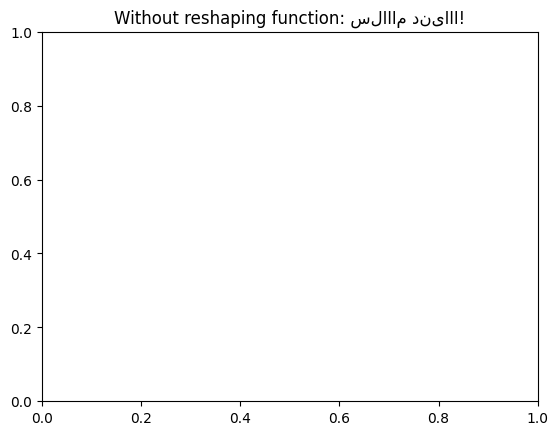

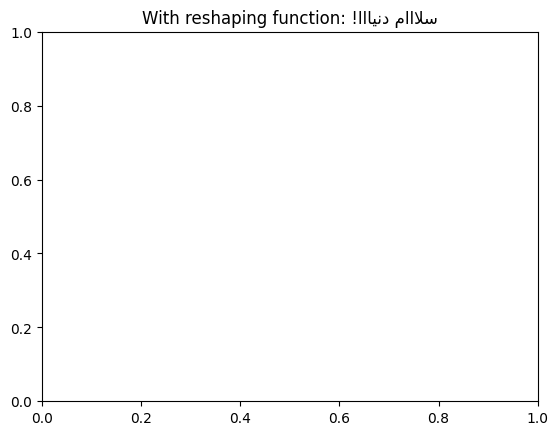

In [24]:
# See an example for a Persian text with an without this function
text = 'سلااام دنیااا!'
plt.title(f'Without reshaping function: {text}')
plt.show()
plt.title(f'With reshaping function: {display_persian(text)}')
plt.show()

### 💡2. *EDA*

Now we can apply some Exploratory Data Analysis (EDA) on our dataset.

- `Understand the Structure of Questions and Answers`: First we display 2 sample questions along with their corresponding answers. Then, we compute the average and median lengths across the entire dataset—both by word count and by character count. Also we will visualize the distribution of lengths using ***Histograms*** to observe shape and ***Boxplots*** to detect outliers and spread.

In [25]:
# Find two first questions
for Q_id in df['QID'].unique()[:2]:
    # First question with this QID
    q_row = df[df['QID'] == Q_id].iloc[0]

    # Display the question
    print('\nQuestion:\n', q_row['QBody'], '\n')

    # Display all answers for that question
    print('Answers:')
    for ans in df[df['QID'] == Q_id]['CBody']:
        print('-' * 5, ans)


Question:
 دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چه کنم؟موضوع دعوامون چیزی بوده که من مقصرش نیستم...خودشم میدونه ربطی به من نداره 

Answers:
----- قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و همین ابتدای زندگیت محوش کن عزیزم
----- انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ادب مي شه كه ديگه قهر نكنه.. البته اگر طاقت مياري كه بهش زنگ نزني اينكاري كه گفتم رو انجام بدي بهترِ عزيزم.
----- تولد براش بگير. قهر جداس
----- تولدشون رو تبریک بگین . جوری که احساس نکنن دارین منت کشی میکنین . یعنی نشون بدین دلخورین . برا این میگم تبریک بگین تا بعداا حرف برا گفتن نداشته باشن .
----- تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نزد. خودت بهش بزنگ بیاد دنبالت بعد کادوشو بهش بده و آشتی کنین و شام برین بیرون چلو کباب برگ سفارش بدین باسوپ جو سالاد فصل و ماست موسیر و زیتون پرورده و دلستر لیمو😋😋
----- . مرسی عزیزم...طاقت میارم اما دوری سردش میکنه. 
----- . میدونم زنگ نمیزنه...اگرم من بزنم دنبالم نمیاد...خودم باید برم دنبالش
----- . دیشب تبریک گفتم جوابی نداد امروزم زنگ زدم برخورد خوبی نداشت
----

In [26]:
# Find unique questions
unique_questions = df[['QID', 'QBody']].drop_duplicates()

# Number of words and characters for each question
unique_questions['Q_word_count'] = unique_questions['QBody'].apply(lambda x: len(str(x).split()))
unique_questions['Q_char_count'] = unique_questions['QBody'].apply(lambda x: len(str(x)))

# Number of words and characters for each answr
df['C_word_count'] = df['CBody'].apply(lambda x: len(str(x).split()))
df['C_char_count'] = df['CBody'].apply(lambda x: len(str(x)))

# Compute mean and median
stats = {
    'Q_word_avg': unique_questions['Q_word_count'].mean(),
    'Q_word_median': unique_questions['Q_word_count'].median(),
    'Q_char_avg': unique_questions['Q_char_count'].mean(),
    'Q_char_median': unique_questions['Q_char_count'].median(),
    'C_word_avg': df['C_word_count'].mean(),
    'C_word_median': df['C_word_count'].median(),
    'C_char_avg': df['C_char_count'].mean(),
    'C_char_median': df['C_char_count'].median(),
}

# Display computed stats
pprint.pprint(stats)

{'C_char_avg': 97.23833348494496,
 'C_char_median': 67.0,
 'C_word_avg': 19.288592740835078,
 'C_word_median': 13.0,
 'Q_char_avg': 172.93232323232323,
 'Q_char_median': 129.0,
 'Q_word_avg': 35.1030303030303,
 'Q_word_median': 26.0}


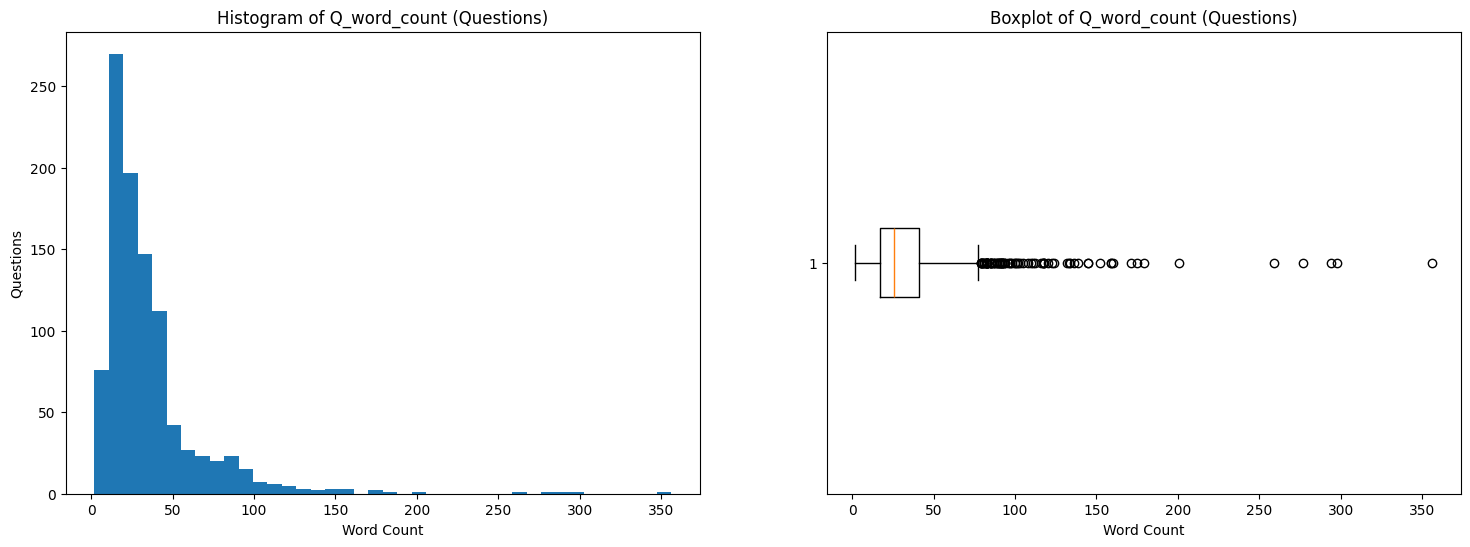

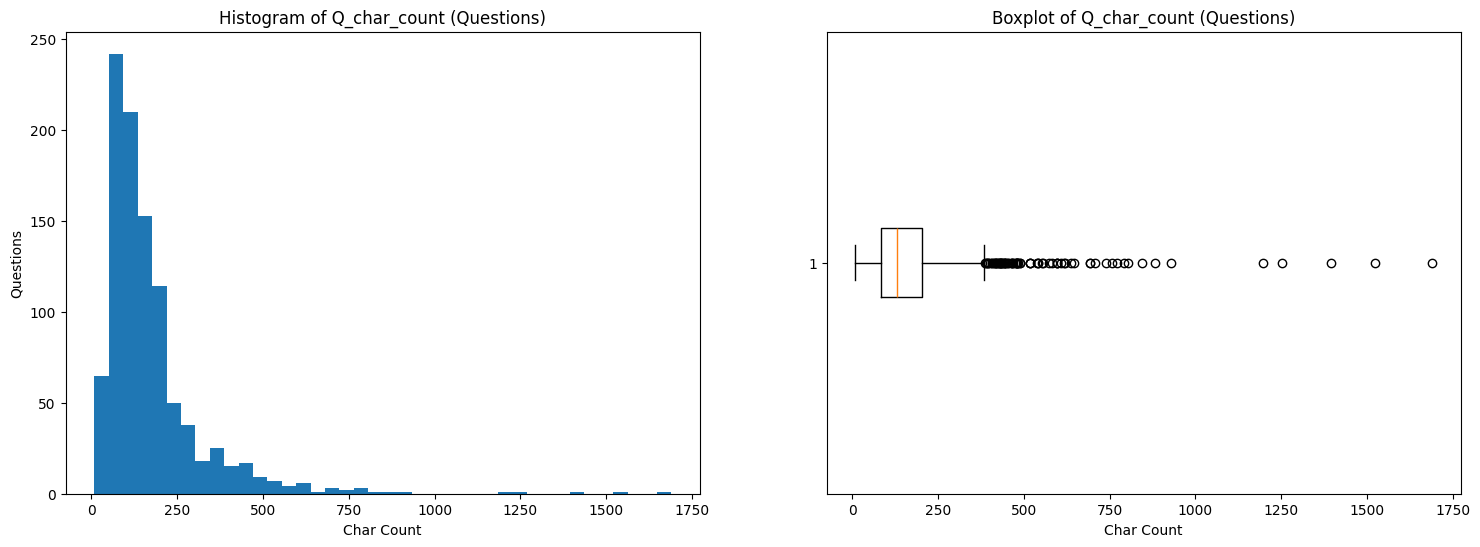

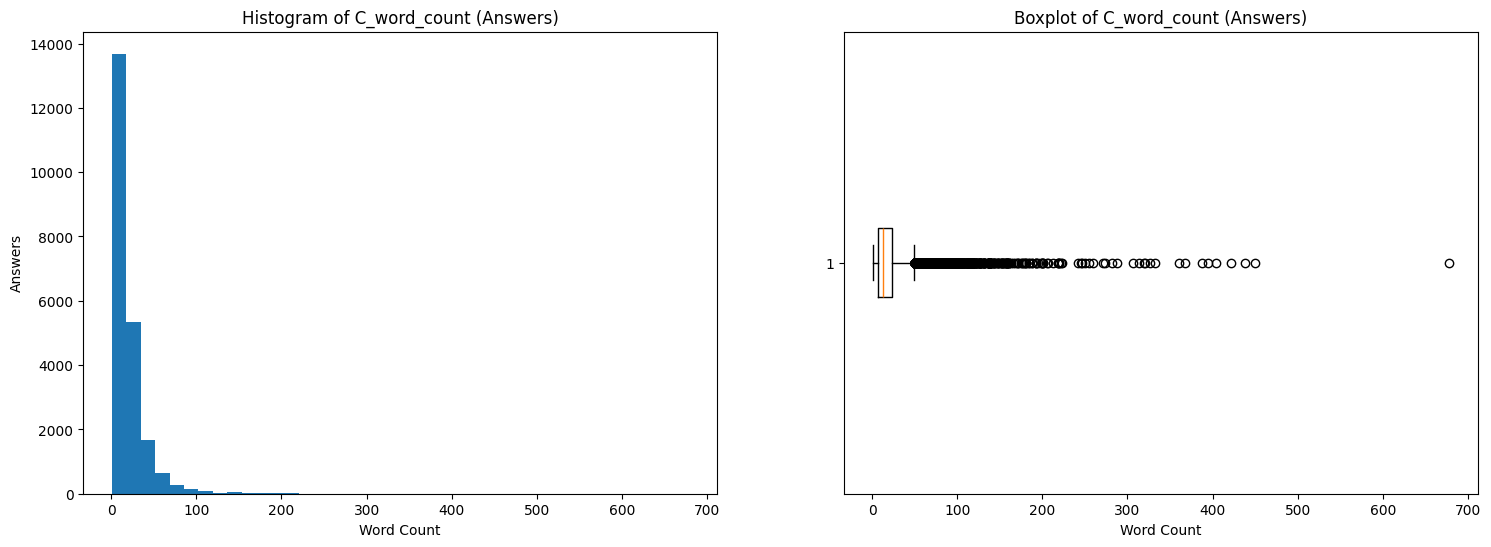

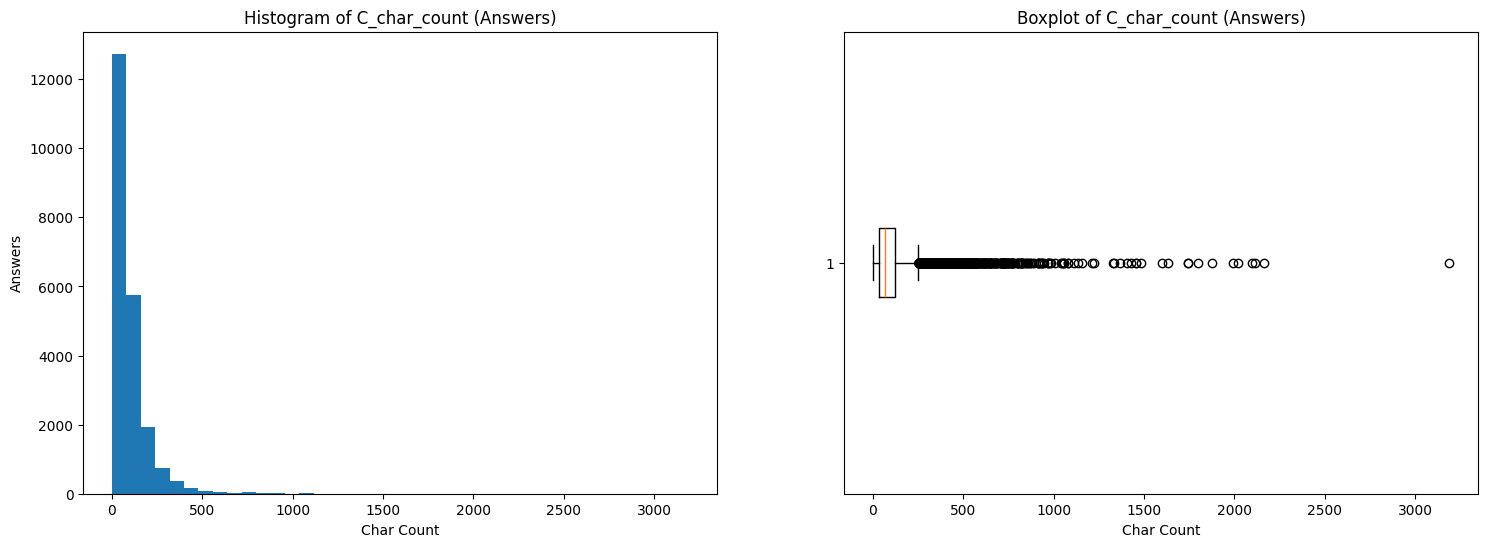

In [27]:
# Plot histogram and boxplot for questions
for col in ['Q_word_count', 'Q_char_count']:
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    unique_questions[col].hist(bins=40)
    plt.grid(False)
    plt.title(f'Histogram of {col} (Questions)')
    plt.xlabel('Word Count' if col == 'Q_word_count' else 'Char Count')
    plt.ylabel('Questions')
    plt.subplot(1, 2, 2)
    plt.boxplot(unique_questions[col], vert=False)
    plt.title(f'Boxplot of {col} (Questions)')
    plt.xlabel('Word Count' if col == 'Q_word_count' else 'Char Count')
    plt.show()

# Plot histogram and boxplot for questions
for col in ['C_word_count', 'C_char_count']:
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    df[col].hist(bins=40)
    plt.grid(False)
    plt.title(f'Histogram of {col} (Answers)')
    plt.xlabel('Word Count' if col == 'C_word_count' else 'Char Count')
    plt.ylabel('Answers')
    plt.subplot(1, 2, 2)
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot of {col} (Answers)')
    plt.xlabel('Word Count' if col == 'C_word_count' else 'Char Count')
    plt.show()

- `Identify the most Engaging Questions`: Here we will find which questions (QID) have the highest number of answers and analyze overall response rates to understand which topics get more attention.

In [28]:
# Number of answers for each question
answer_counts = df.groupby('QID').size().reset_index(name='AnswerCount')

# Find top 10 most answered questions
top_answered_questions = answer_counts.sort_values(by='AnswerCount', ascending=False).head(10)

# Display top 10 questions 
top_questions = top_answered_questions.merge(df[['QID', 'QBody']].drop_duplicates(), on='QID')
for _, row in top_questions.iterrows():
    print('QID:', row['QID'])
    print('Question:', row['QBody'])
    print('Number of Answers:', row['AnswerCount'])
    print('=' * 80)

QID: 1556257
Question: با ١٥ تومن چه چيزاي از جهاز و ميشه خريد ؟! كه هم أساسي باشه هم بدرد بخور اگ به عبارات ديگ فقط ١٥-٢٠ تومن برا خريد جهيزيه داشته باشين چه چيزهاي ميخريد و چطور از همسرتون ميخواين كه در خريد كمك كنه؟  جوري كه  هم غرورمن حفظ بشه هم شوهر قانع بشه و بهش برنخوره.  تا حالا هم در اين مورد هيچ حرفي با هم نزديم 
Number of Answers: 315
QID: 1577970
Question: کسی اطلاع داره بخوابم پیش ایشون بريم چطوری و کجا باید هماهنگ کنیم?
Number of Answers: 313
QID: 1559359
Question: بعد طلاق چطور خودتونو سرپا نگه داشتین. چطور خودتونو جمع کردین؟  
Number of Answers: 215
QID: 1555428
Question: من یه سال نامزد کردم قرار یه سال دیگه هم نامزد بمونیم عقد کردیم نامزدم و خانوادش اصلا حرفی از نامه سلامت اینا نزدن ولی مامانم همش میگه نه باید بری من چی کنم بدم میاد اخه به نامزدمم گفتم.  گفت خودت میدونی می خوای برو بگیر ولی لزومی نداره (یجوری گفت انگار بی میل هم نبود ). برم یا نه ؟ 
Number of Answers: 215
QID: 1578477
Question: بیاین بگین چیکار میکنین نازتونو میکشه؟. من شوهرم روزی 2بار خودش زنگ میزنه 

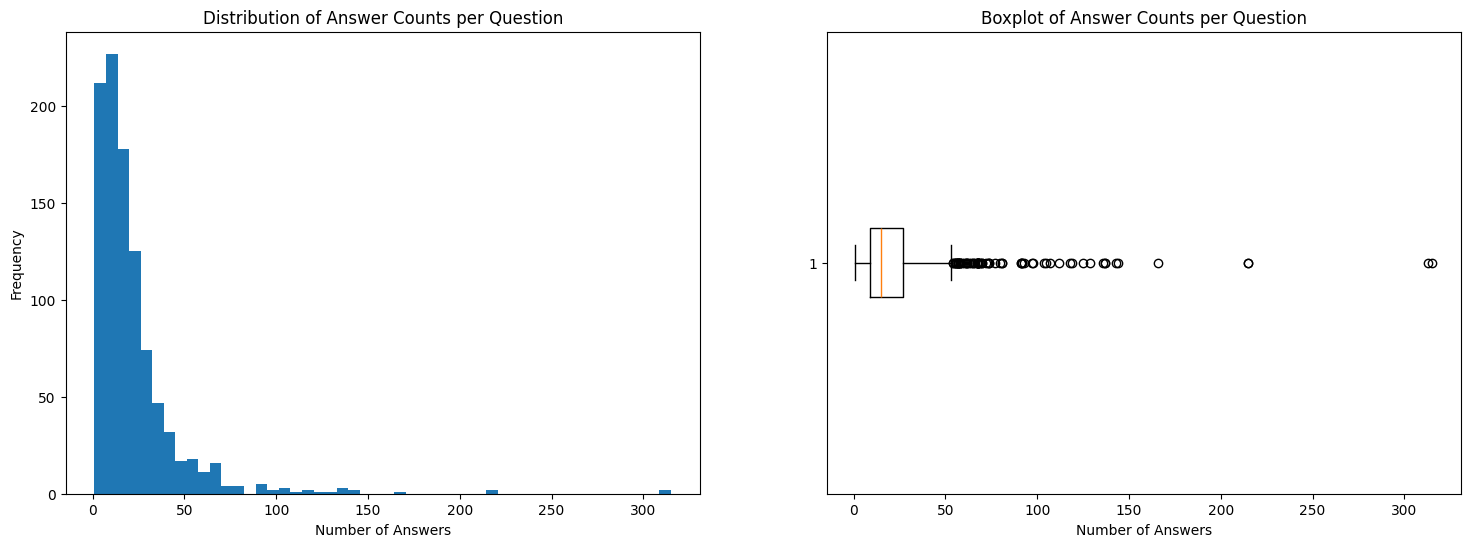

In [29]:
# Plot histogram and boxplot for answer counts per question
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(answer_counts['AnswerCount'], bins=50)
plt.title('Distribution of Answer Counts per Question')
plt.xlabel('Number of Answers')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.boxplot(answer_counts['AnswerCount'], vert=False)
plt.title('Boxplot of Answer Counts per Question')
plt.xlabel('Number of Answers')
plt.show()

- `Analyze User Activity Patterns`: Using the *CDate* field, we will determine peak hours and days when users are most active so we can identify when the platform is most responsive. So we can visualize this using line charts and bar plots for hourly/daily activity.

In [30]:
# Make this field's type to datetime 
df['CDate'] = pd.to_datetime(df['CDate'], errors='coerce')

# Build new wanted time columns
df['Hour'] = df['CDate'].dt.hour
df['DayOfWeek'] = df['CDate'].dt.day_name()
df['Date'] = df['CDate'].dt.date

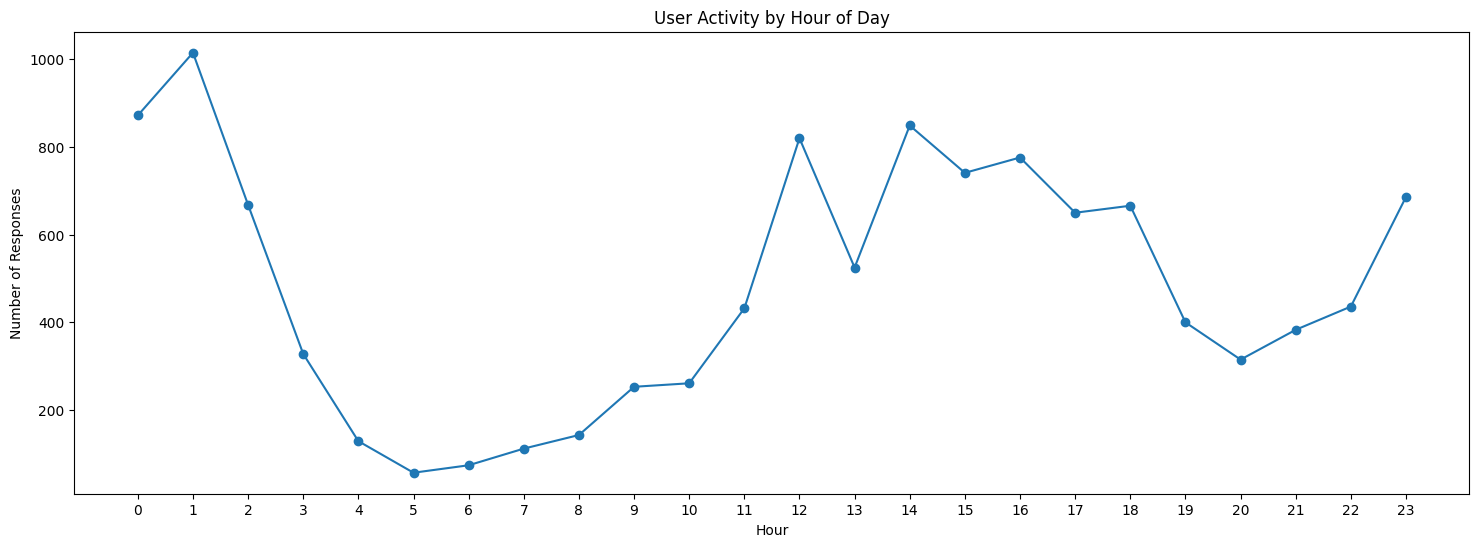

In [31]:
# Find users hourly activity
hourly_activity = df.groupby('Hour').size().reset_index(name='ResponseCount')

# Plot line chart for user activity on each hour
plt.figure(figsize=(18, 6))
plt.plot(hourly_activity['Hour'], hourly_activity['ResponseCount'], marker='o')
plt.xticks(range(0, 24))
plt.title('User Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Responses')
plt.show()

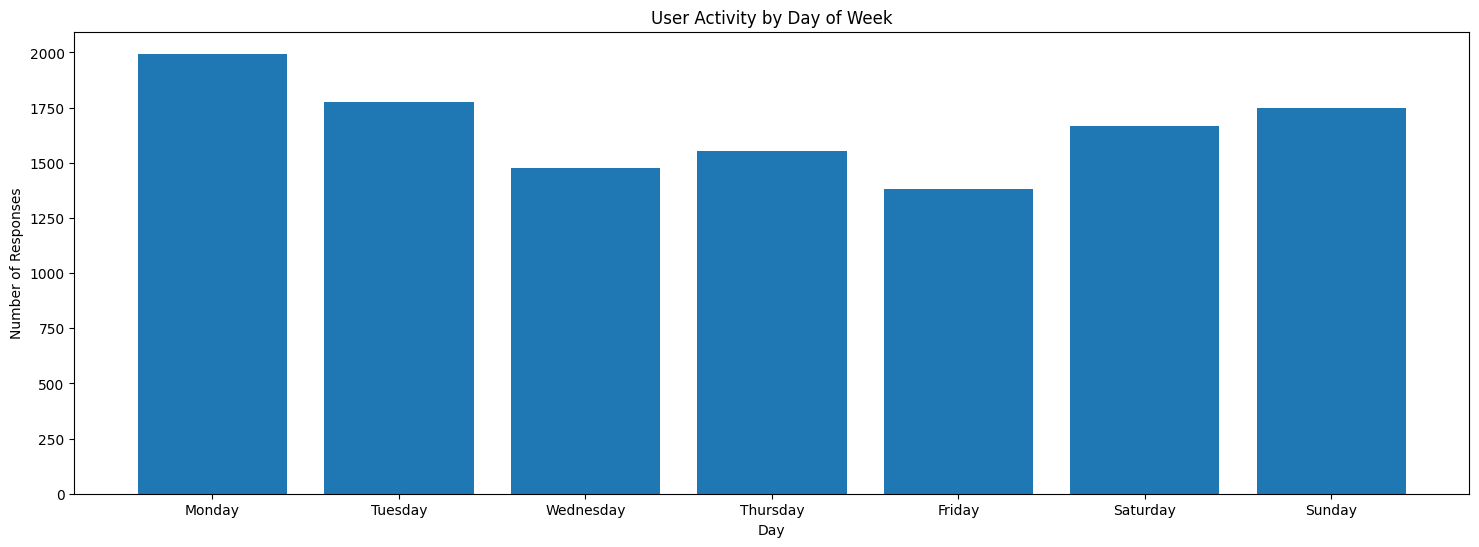

In [32]:
# Find users daily activity
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = df.groupby('DayOfWeek').size().reindex(days_order).reset_index(name='ResponseCount')

# Plot bar plot for user activity on each day
plt.figure(figsize=(18, 6))
plt.bar(daily_activity['DayOfWeek'], daily_activity['ResponseCount'])
plt.title('User Activity by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Responses')
plt.show()

- `Detect Top Answer Contributors`: Here we count the number of answers posted by each user (CUsername). Then we create a bar chart of the top 10 contributors to show who is most
active in the community.

In [33]:
# Find and display the number of answers posted by each user
num_contributors = df['CUsername'].value_counts()
num_contributors

CUsername
باران_بهاری95    142
بلوبری۳۲۳۷        96
a_rezoo           93
saghiiii          89
عسلیk516          86
                ... 
مامان_اسرا         1
abremaman          1
mzf                1
لیااناا            1
mahboub            1
Name: count, Length: 6283, dtype: int64

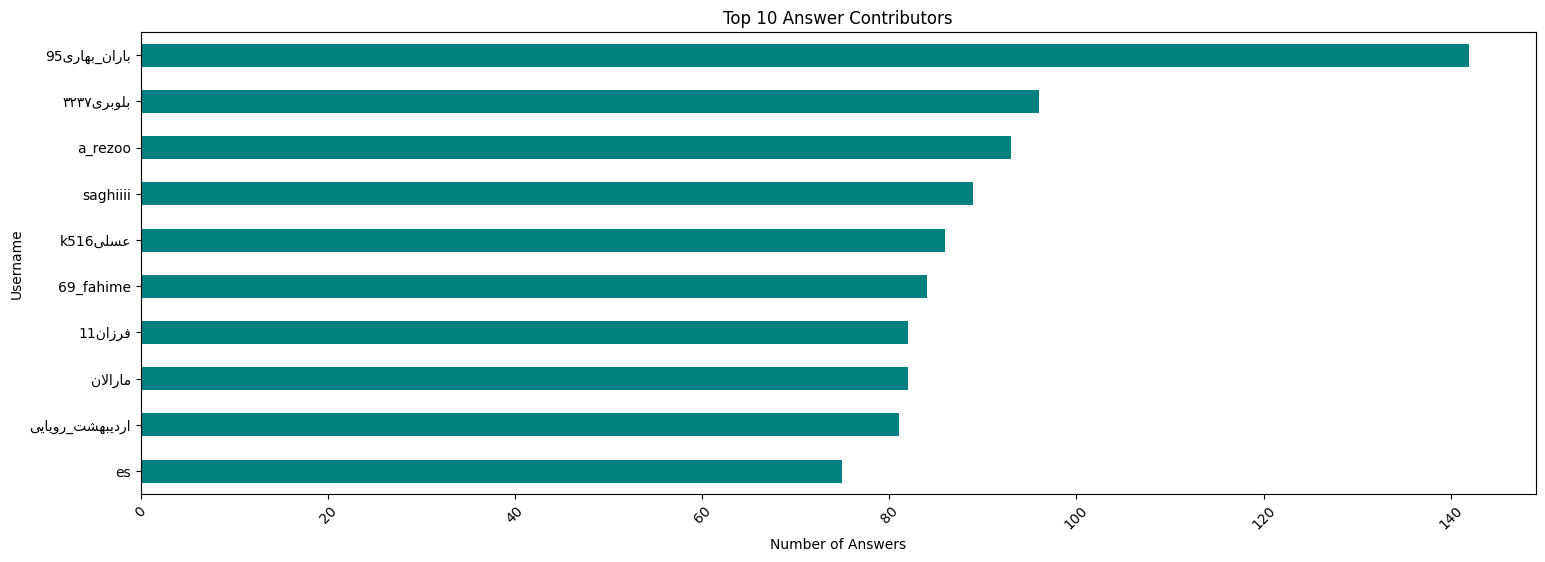

In [34]:
# Fid top 10 contributors
top_contributors = num_contributors.head(10)
top_contributors.index = top_contributors.index.map(display_persian)

# Plot bar chart of the top 10 contributors
plt.figure(figsize=(18, 6))
top_contributors.sort_values().plot(kind='barh', color='teal')
plt.title('Top 10 Answer Contributors')
plt.xlabel('Number of Answers')
plt.ylabel('Username')
plt.xticks(rotation=45)
plt.show()

- `Linguistic and Word-Level Analysis`: First we extract and visualize most frequently used words in answers. Next we generate word cloud to capture common language patterns and user concerns. Also we go deeper with n-gram analysis, with plotting unigram, bigram, and trigram frequencies. We perform this both before and after stopword removal to observe the effect on meaningful patterns.

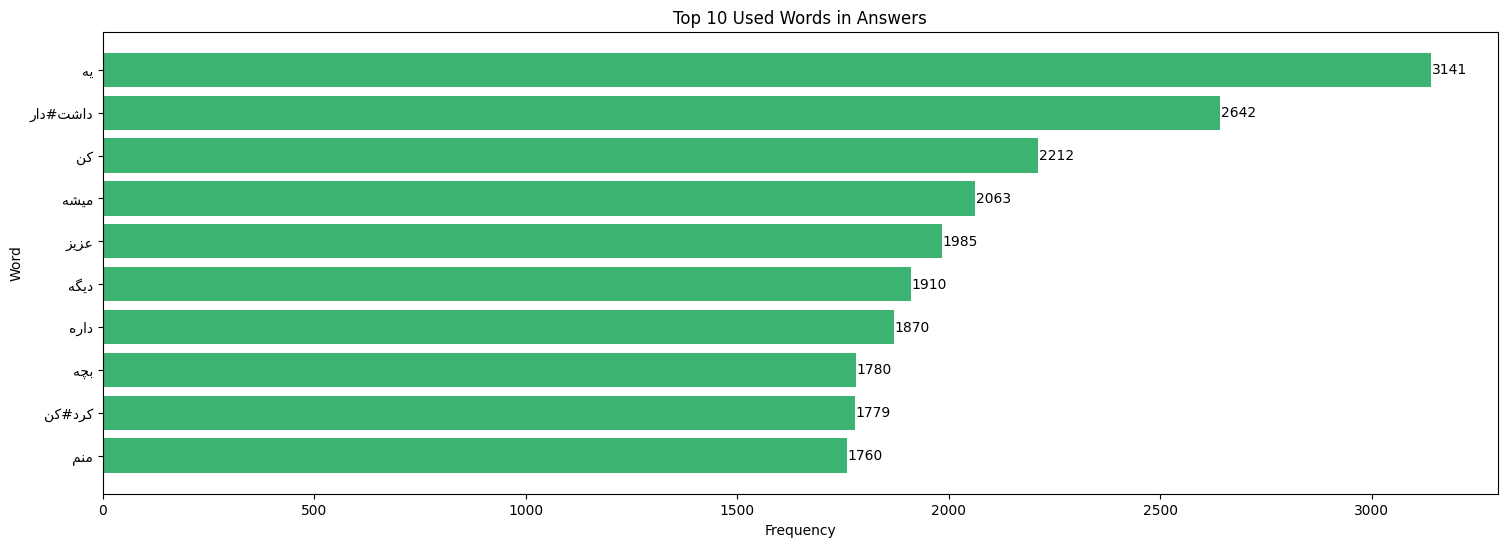

In [35]:
# Find top 10 most frequently used words in answers 
all_answer_words = list(chain.from_iterable(df['CBody_Tokenized']))
answer_word_counts = Counter(all_answer_words)
adjusted_top_words = [display_persian(word) for word, _ in answer_word_counts.most_common(10)]
frequencies = [freq for _, freq in answer_word_counts.most_common(10)]

# Plot bar chart of the top 10 used words in answers
plt.figure(figsize=(18, 6))
for i, freq in enumerate(frequencies):
    plt.barh(i, freq, color='mediumseagreen')
    plt.text(freq + 1, i, str(freq), va='center')
plt.yticks(range(len(adjusted_top_words)), adjusted_top_words)
plt.title('Top 10 Used Words in Answers')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.gca().invert_yaxis()
plt.show()

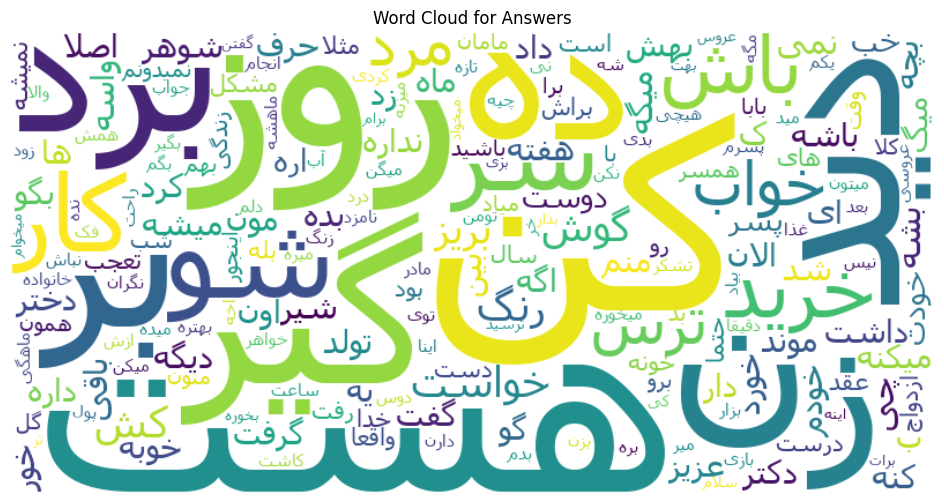

In [36]:
# Plot word cloud for answers
adjusted_all_words = [display_persian(word) for word, _ in answer_word_counts.most_common(1000)]
text = ' '.join(adjusted_all_words)
wordcloud = WordCloud(font_path=r"C:\Windows\Fonts\Tahoma.ttf", background_color='white', width=800, height=400).generate(text)
plt.figure(figsize=(18, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Answers')
plt.show()

In [37]:
# Function to calculate n-gram frequencies
def ngram_freq(texts, n):
    vec = CountVectorizer(ngram_range=(n, n), analyzer='word')
    ngram_matrix = vec.fit_transform(texts)
    freqs = ngram_matrix.sum(axis=0).A1
    ngram_vocab = vec.get_feature_names_out()
    freq_dict = dict(zip(ngram_vocab, freqs))
    sorted_ngrams = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:15]

    return sorted_ngrams

# Make n-grams before removing stopwords
unigrams_with_stopwords = ngram_freq(df['CBody_Tokenized_with_stopwords'].apply(lambda tokens: ' '.join(tokens)), 1)
bigrams_with_stopwords = ngram_freq(df['CBody_Tokenized_with_stopwords'].apply(lambda tokens: ' '.join(tokens)), 2)
trigrams_with_stopwords = ngram_freq(df['CBody_Tokenized_with_stopwords'].apply(lambda tokens: ' '.join(tokens)), 3)

# Make n-grams after removing stopwords
unigrams_without_stopwords = ngram_freq(df['CBody_Tokenized_without_stopwords'].apply(lambda tokens: ' '.join(tokens)), 1)
bigrams_without_stopwords = ngram_freq(df['CBody_Tokenized_without_stopwords'].apply(lambda tokens: ' '.join(tokens)), 2)
trigrams_without_stopwords = ngram_freq(df['CBody_Tokenized_without_stopwords'].apply(lambda tokens: ' '.join(tokens)), 3)

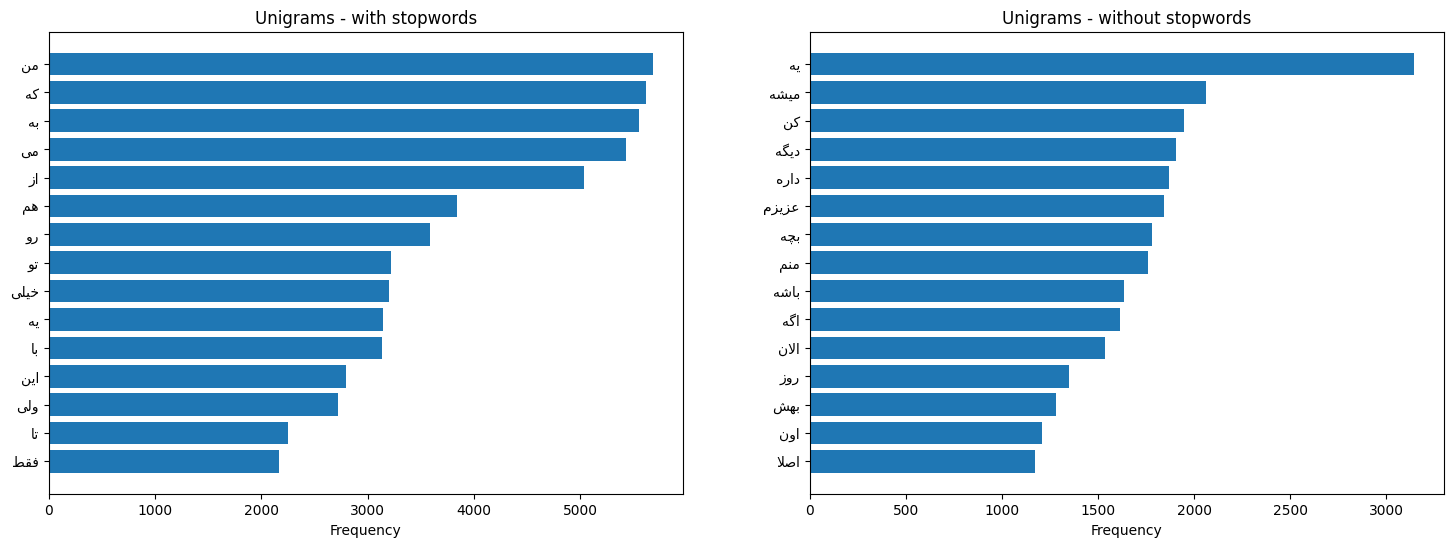

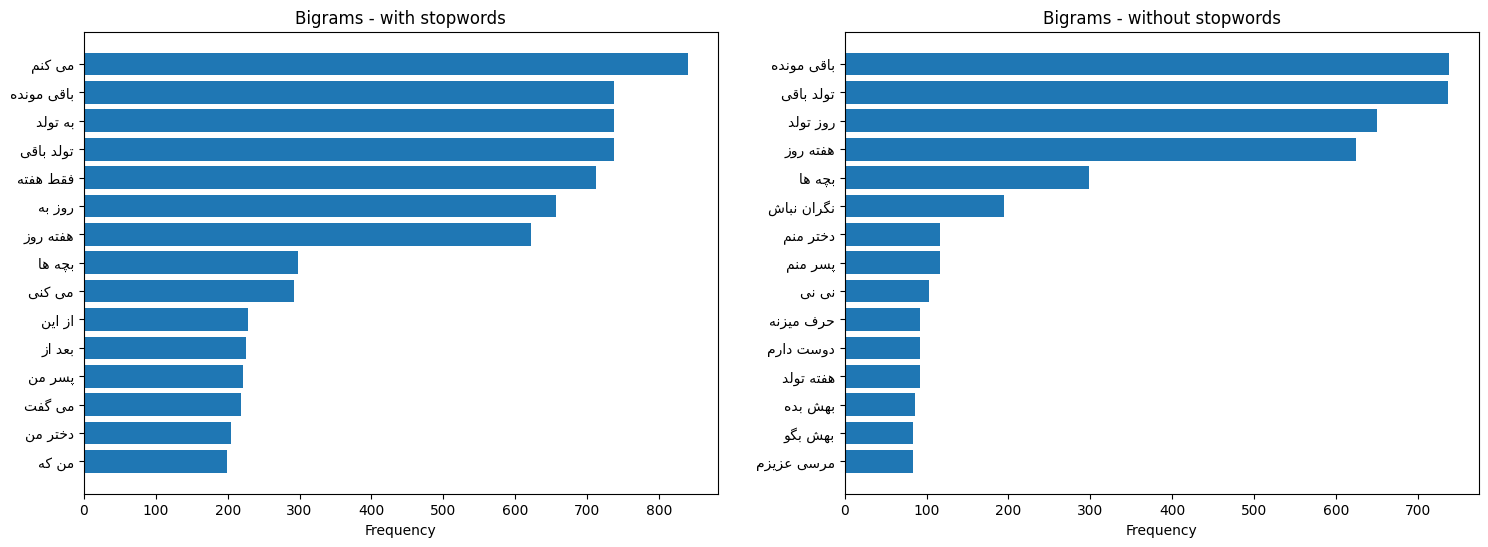

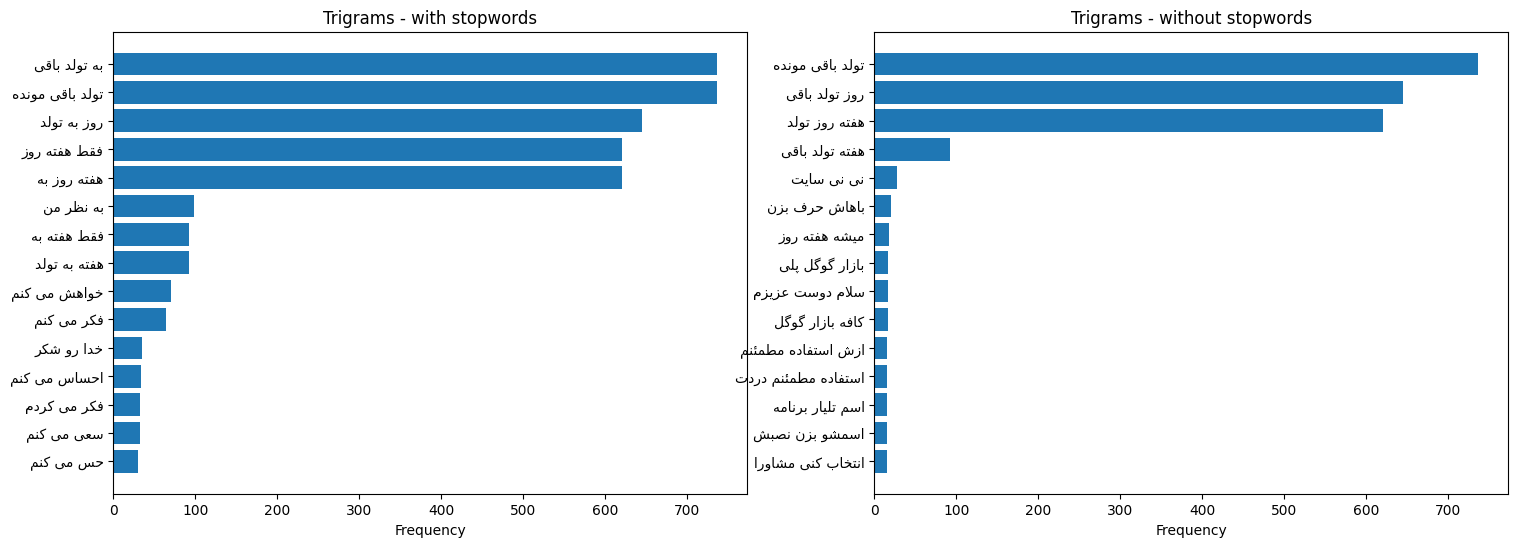

In [38]:
# Function to plot n-grams
def plot_ngram(ngram_data_before, ngram_data_after, title):
    terms_before, freqs_before = zip(*ngram_data_before)
    terms_after, freqs_after = zip(*ngram_data_after)
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.barh([display_persian(term) for term in terms_before], freqs_before)
    plt.title(f'{title} - with stopwords')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    plt.subplot(1, 2, 2)
    plt.barh([display_persian(term) for term in terms_after], freqs_after)
    plt.title(f'{title} - without stopwords')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    plt.show()

# Plot n-grams
plot_ngram(unigrams_with_stopwords, unigrams_without_stopwords, 'Unigrams')
plot_ngram(bigrams_with_stopwords, bigrams_without_stopwords, 'Bigrams')
plot_ngram(trigrams_with_stopwords, trigrams_without_stopwords, 'Trigrams')

### 💡3. *Analyse the Dataset*

Now we want to improve the site's internal search functionality. Currently, the site uses traditional keyword-based search algorithms, which are insufficient for retrieving results that are semantically similar to a user's query. To solve this problem, we propose using embedding-based search that captures the meaning of queries rather than just matching keywords. We choose  ***bge-m3***, a multilingual embedding model capable of capturing semantic similarity across various languages. Also to store and search embeddings efficiently, we decide to use ***LanceDB***, a vector database that is easy to set up and integrates well with modern embedding workflows.

- `Load the bge-m3 Embedding Model and Test it`: First we use the model to encode the QBody (question body) of a random row from the dataset. Then we analyze the output of the model and we can answer these questions:

    - *What does it return?*
        - The output of the bge-m3 embedding model is a vector of 1024 floating-point numbers. This vector serves as a numerical representation of the semantic meaning of the input sentence. Such a vector is referred to as a semantic embedding, and it captures the contextual and conceptual relationships within the text. Sentences with similar meanings tend to have embeddings that are close to each other in this high-dimensional space, making them useful for tasks like semantic search.

    - *What do the components of the output represent? Explain their meanings and potential uses.*
        - Each element in this vector (i.e., embedding[i]) represents a latent semantic feature. Similar questions produce embeddings that are close together using cosine similarity, making them ideal for tasks such as semantic search, duplicate question detection, and clustering by topic. Since bge-m3 is multilingual, it effectively handles Persian questions and supports cross-lingual semantic similarity. These embeddings are foundational for building a more intelligent and meaning-aware search system.

In [39]:
# First load the dataset again
df = pd.read_json('PerCQA_JSON_Format.json', encoding = 'utf=8=sig')

In [40]:
# Show the dataframe
df

,QID,QCATEGORY,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,QBody,QSubject,Comments
0,1550088,NaN,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,"[{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':..."
1,1558609,NaN,2018-01-06T00:17:00,6856,General,Not Applicable,khanoomi72,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...,بزرگترین اشتباه دوران نامزدیتون چی بوده؟؟,"[{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':..."
2,1587820,NaN,2018-01-22T13:23:00,9918,General,Not Applicable,lol,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....,کمک سالگرد ازدواجم نزدیکه,"[{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'..."
3,4414921,NaN,2020-05-23T02:06:00,81403,General,Not Applicable,sepide1400,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...,متخصص ارتوپدی برای درمان پرانتزی پا,"[{'CID': '138006316', 'CUSERID': 38437, 'CGOLD..."
4,3109668,NaN,2019-08-13T12:07:00,25700,General,Not Applicable,نسا۷۹,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...,لپ پسرم قرمز دون دونه,"[{'CID': '100859930', 'CUSERID': 33391, 'CGOLD..."
...,...,...,...,...,...,...,...,...,...,...
985,1582862,NaN,2018-01-19T14:50:00,9379,General,Not Applicable,مامان_مهراد_جونی,هدایایی که برای بله برون می برن تو شهرهای مختل...,بله برون. خانمای میشه بگید برای بله بران چه چی...,"[{'CID': '52145320', 'CUSERID': 10177, 'CGOLD'..."
986,1790522,NaN,2018-05-20T00:46:00,12482,General,Not Applicable,_مهربانو_,براي اولين بار كره ي بادوم زميني خريدم ولي نمي...,با كره ي بادوم زميني چي درست كنم؟,"[{'CID': '59550231', 'CUSERID': 13736, 'CGOLD'..."
987,1574016,NaN,2018-01-14T11:51:00,9753,General,Not Applicable,مارالان,من ۹ماهه که عقد کردم . نامزدم ماهی۱۱۰۰حقوقشه ت...,نامزدی,"[{'CID': '51780636', 'CUSERID': 9563, 'CGOLD':..."
988,4171615,NaN,2020-04-06T18:17:00,30885,General,Not Applicable,saghiiii,بچه ها از کی به نبودن شیر عادت میکنن؟ ۳ روزه گ...,از شیر گرفتن کودک,"[{'CID': '131471418', 'CUSERID': 6245, 'CGOLD'..."


In [41]:
# Load the bge-m3 model
model = SentenceTransformer('BAAI/bge-m3')

In [42]:
# Select a random wuestion
random_row = df.sample(1).iloc[0]
random_question = random_row['QBody']

print('Sample Question Body:\n', random_question)

Sample Question Body:
 دخترم ۲۳ ماهش هست. تقریبا یک ماه دیگه دو ساله میشه .تقریبا ده تا کلمه رو کامل میگه ولی اصلا جمله نمیتونه بگه . بنظرتون مشکل گفتاری داره؟نیاز هست ببرمش دکتر؟


In [43]:
# Encode the selected question by our model
random_question_embedding = model.encode(random_question)

print('Embedding Vector Shape:\n', random_question_embedding.shape)
print('Embedding Vector Values:\n', random_question_embedding[:20])

Embedding Vector Shape:
 (1024,)
Embedding Vector Values:
 [ 0.00812951  0.0170048  -0.02671434 -0.01826048 -0.02655832 -0.0097899
 -0.03158511  0.00867535  0.00213228  0.00297617  0.00038561 -0.00948188
  0.00345793  0.00800208  0.00786906  0.02139444 -0.00723122 -0.0150602
 -0.01368398  0.00742853]


- `Install LanceDB and Set Up an Embedding Function`: First we installed the LanceDB Python library. Then using the TextEmbeddingFunction class (a class from LanceDB for convert text to embedding using our model), we can define a custom embedding function that uses the bge-m3 model to encode question texts. We only use the dense embeddings.

    - *Dense Embeddings*: Dense embeddings are fixed-length vectors where all dimensions contain real values. They are generated by modern language models like bge-m3 and capture the full semantic meaning of a sentence.

    - *Sparse Embeddings*: Sparse embeddings, like those from TF-IDF or BM25, represent text based on word frequency. Most values are zero, and each dimension corresponds to a specific word in the vocabulary.

In [44]:
# Class to apply embedding function with only dense embeddings
@register('bge-m3')
class bgeEmbedding(TextEmbeddingFunction):
    name: str = 'BAAI/bge-m3'

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._ndims = None

    def generate_embeddings(self, texts):
        return self._model().encode(texts, normalize_embeddings=True).tolist()

    def ndims(self):
        if self._ndims is None:
            self._ndims = len(self.generate_embeddings(['متن فارسی'])[0])
        return self._ndims
    
    @lru_cache()
    def _model(self):
        return SentenceTransformer(self.name)
        
# Define an embedding function
embedding_function = bgeEmbedding.create()

- `Define a Schema for our Vector Database`: Our schema must include at least qid (a unique identifier for each entry), qbody (the raw question text), and embedding (the vector representation of the qbody using our custom embedding function).

In [45]:
# Class to define our schema
class QuestionSchema(LanceModel):
    qid: int
    qbody: str = embedding_function.SourceField()
    embedding: Vector(embedding_function.ndims()) = embedding_function.VectorField()

- `Create and Populate a LanceDB Table`: Now we create a new table using our defined schema. Then load the Nini Site dataset (questions only, excluding comments) into this table. The embeddings must be generated automatically by LanceDB using the custom embedding function and should not compute the embeddings manually before inserting the data into the database.

In [46]:
# First connect to the LenceDB
db = lancedb.connect('/content/ninisite_db')

# Create a new table
table_questions = db.create_table(
    name='questions',
    schema=QuestionSchema,
    mode='overwrite'
)

# Create questions dataframe
df_questions = df[['QID', 'QBody']].dropna().rename(columns={'QID': 'qid', 'QBody': 'qbody'})

# Load the questions dataset to the table
table_questions.add(df_questions)

AddResult(version=4)

In [47]:
# Show the table as a Pandas dataframe
table_questions.to_pandas()

,qid,qbody,embedding
0,1550088,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,"[0.043938138, 0.036640055, -0.010585845, -0.01..."
1,1558609,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...,"[-0.03775335, -0.0014564815, -0.030918468, -0...."
2,1587820,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....,"[-0.02995132, 0.0673064, -0.038232263, 0.03607..."
3,4414921,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...,"[-0.031048283, 0.018678501, -0.044434622, 0.01..."
4,3109668,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...,"[-0.01734402, 0.03248696, -0.061496746, 0.0007..."
...,...,...,...
985,1582862,هدایایی که برای بله برون می برن تو شهرهای مختل...,"[-0.029458793, 0.06605113, -0.016618917, 0.002..."
986,1790522,براي اولين بار كره ي بادوم زميني خريدم ولي نمي...,"[-0.017698674, 0.025286892, -0.035241578, -0.0..."
987,1574016,من ۹ماهه که عقد کردم . نامزدم ماهی۱۱۰۰حقوقشه ت...,"[-0.011578449, 0.057264008, -0.026342329, -0.0..."
988,4171615,بچه ها از کی به نبودن شیر عادت میکنن؟ ۳ روزه گ...,"[-0.029025795, 0.030614732, -0.010910896, -0.0..."


- `Perform Semantic Search with LanceDB`: Now we can retrieve the top 5 semantically similar results for at least 5 different user queries using LanceDB’s search function. Also we evaluate whether the results are semantically relevant to the query manually.

In [48]:
# Write 5 queries searched by users
user_queries = [
    'چطور بفهمم باردارم؟',
    'علائم افسردگی در نوجوانان چیه',
    'چرا بعضی شب‌ها خوابم نمی‌بره؟',
    'روش‌های خانگی درمان جوش صورت',
    'چه غذاهایی برای کاهش کلسترول خوبه؟'
]

# Search and display top 5 similar results for each query using semantic search
for query in user_queries:
    print(f'\nQuery:\n {query}\n')

    results = table_questions.search(query).limit(5).select(['qbody']).to_pandas()

    for _, row in results.iterrows():
        print('- Distance:')
        print(row['_distance'])
        print('- Qbody:')
        print(row['qbody'])
        print('=' * 80)


Query:
 چطور بفهمم باردارم؟

- Distance:
0.7492178678512573
- Qbody:
یک دختر بیست ماهه دارم.  باید هجدهم ماه  پریود میشدم ولی هنوز پریود نشدم یعنی باردارهستم؟
- Distance:
0.7518839836120605
- Qbody:
من تازه متوجه شدم باردارم. سه روز قبل موعد پریودم فهمیدم. بتام ۹۴ بود . بعد امروز رفتم دکتر گفت چون تعطیلات بذار سنو کنم شاید چیزی معلوم شد . که چیزی مشخص نبود و یک کیست کوچولو داشتم. بعد گفت ۱۰ درصد شاید خارج رحمی باشه. و گفت روز موعدم دوباره آزمایش و تکرار کنم و ۳ برم برای اینکه ببینم کیسه تشکیل شده یا نه. از روی جواب آزمایش میشه فهمید بارداری خارج رحمی هست یا نه؟
- Distance:
0.7908710241317749
- Qbody:
من ۲۰ هفته ام شده.  فقط ضربه های ریز توی  شکمم حس میشه. از کی تکانهای‌ واضح بچه هاتون رو تشخیص دادین؟ جوری که حرکاتش روی شکمتون معلوم باشه  ؟ 
- Distance:
0.8199080228805542
- Qbody:
تو بارداری میشه مشکل ذهنی و جسمی بچه رو تشخیص داد؟ امروز یه پیجی دیدم تو اینستا بچشون سندروم نمیدونم چی داشت از اون موقع استرس گرفتم 
- Distance:
0.839698851108551
- Qbody:
الان ۳۶ هفته و۴ روزم هست ‌  اخرین ب

- `Implement Classical Full-Text Search using LanceDB`: Now we index (the process of creating a structured summary of your data to enable faster search) fields for full-text search and create a full-text index on qbody and perform previously 5 queries. Then we compare the results with those from semantic search. 

    - *Which approach gives more relevant results?*
        - We can observe that ***semantic search*** gives more relevant and better results, which finds results based on meaning using vector embeddings, while full-text search relies on exact keyword matching. Semantic search handles synonyms and rephrased questions better, making it more accurate for user queries.

Semantic search ranks results based on the ***distance*** between vector embeddings, smaller distance means higher similarity in meaning. Full-text search uses a ***score*** based on keyword matches, higher score means more matched or important terms.

In [50]:
# Create a full-text search index on qbody
table_questions.create_fts_index('qbody', replace=True)

# Search and display top 5 similar results for each query using full-text search
for query in user_queries:
    print(f'\nQuery:\n {query}\n')

    results = table_questions.search(query, query_type='fts').limit(5).select(['qbody']).to_pandas()

    for _, row in results.iterrows():
        print('- Score:')
        print(row['_score'])
        print('- Qbody:')
        print(row['qbody'])
        print('=' * 80)


Query:
 چطور بفهمم باردارم؟

- Score:
23.73419189453125
- Qbody:
چطور دکتریه؟کسی بچش برده
- Score:
20.110172271728516
- Qbody:
کسایی که وام دانشجویی گرفتن،  اقساطش چطور بود و چقد بعد فارغ تحصیلی ادامه داشت؟ 
- Score:
19.807722091674805
- Qbody:
میخوام برا نامزدم یه شال گردن ببافم بهم میگین چطور میتونم یاد بگیرم به جز کلاس
- Score:
18.952606201171875
- Qbody:
کسی به بچش شربت زینک سانستول داده؟ چطور بود؟  تاثیرش خوبه؟ امروز یکی بهم معرفی کرد برای رشد موهاش.
- Score:
15.774593353271484
- Qbody:
خانوما با بچه های ۱/۵ساله چه بازی هایی میکنید؟ چه کاردستی درست میکنید برای یادگیری و مهارتشون؟چه چیزایی یادشون میدین کلمه هارو چطور بهشون یاد میدید؟ چه کتابایی باهاشون کار میکنید؟

Query:
 علائم افسردگی در نوجوانان چیه

- Score:
29.09142303466797
- Qbody:
من از رنگ کردن مو هیچی نمیدونم. هایلایت چیه؟  مش چیه؟ دکلره چیه؟ آمبره چیه؟ لطفا برای رنگ کردن راهنماییم کنین 
- Score:
21.202356338500977
- Qbody:
 چه پمادی بزنم و از چیه اینجور شده  . واضح نیس بزور ازش عکس گرفتم 
- Score:
20.98303985595703
- Qb

- `Research Hybrid Search Techniques`: We can investigate and explain that:

    - *What is hybrid search?*
        - Hybrid search combines both semantic search (based on vector similarity) and full-text search (based on keyword matching) into a single search strategy. Instead of choosing one method, hybrid search uses both and merges their outputs—either by scoring, ranking, or filtering. First in its ***semantic component***, it converts queries and documents into dense vectors using embedding models (e.g., bge-m3), then finds the closest matches based on cosine or Euclidean distance. Then in ***full-text*** component, it performs traditional keyword-based matching using techniques like BM25 or TF-IDF. Then, the two result sets are combined, often by ***weighted scoring*** (e.g., 70% semantic, 30% keyword), ***filtering*** (semantic matches filtered by keyword hits), or ***re-ranking*** based on user context.


    - *Explain why hybrid search might be more effective than using one method alone?*
        - Because each method has limitations. Semantic search understands meaning, but might miss exact matches or rare keywords. Full-text search finds exact terms, but struggles with synonyms, rephrasing, or context. But, by combining both, hybrid search improves recall (finds more relevant results), boosts precision (filters out irrelevant ones), and handles edge cases, such as slang, spelling variations, or user typos.

- `Evaluation Methods`: So far, we have manually checked whether the results were good or not. Here are some common evaluation metrics for search systems:

    - **Precision@k** -> Measures the proportion of relevant results in the top k retrieved items. Higher precision means more relevant items appear early. It is useful when users care most about seeing a few highly relevant results (e.g., top 5).

    $$ Precision@k = \frac{\text{number of relevant results in top } k}{k} $$

    - **Recall** -> Measures the proportion of all relevant items that were successfully retrieved and focuses on coverage rather than ranking. It is useful when it’s critical to find as many relevant results as possible (e.g., medical retrieval).

    $$ Recall = \frac{\text{number of all successfully relevant results}}{\text{total number of all relevant results}} $$

    - **NDCG (Normalized Discounted Cumulative Gain)** -> Measures ranking quality by giving higher importance to relevant documents appearing earlier in the result list and evaluates ranking based on both relevance and position in the result list. Normalized, so values range from 0 (bad rank) to 1 (good rank). It is useful for evaluating ranked search results, such as in web search engines.

    $$ DCG = \sum_{i=1}^{k} \frac{rel_i}{\log_2(i + 1)} $$

    $$ NDCG = \frac{\text{DCG}}{\text{IDCG}} $$

    Where $rel_i$ is the relevance of the result at position $i$, and $IDCG$ is the ideal (best) DCG (i.e., the best possible ranking).

### 💡4. *Answer Ranking Enhancement with a Reranker*

After performing semantic search and retrieving relevant answers, we can apply a reranker model to improve the ranking of the results. A reranker evaluates each (question, answer) pair more precisely to determine better relevance ordering. Here we can use a ready-made model, such as bge-reranker or a cross-encoder from the sentence-transformers library, which we choose ***cross-encoder***.

- ***Reranker model***: While semantic search using embeddings provides a fast and meaningful initial retrieval, it does not deeply evaluate how well each answer matches the user's question. A reranker is a machine learning model that takes each (question, answer) pair and evaluates how semantically relevant the answer is to the question. It then assigns a refined relevance score to each pair. As a result, we get a reordered list of answers, ranked more precisely based on their actual relevance to the user's query. Two ready-made models that we can use:

    - ***bge-reranker*** -> The bge-reranker is a lightweight and efficient reranker model developed by BAAI. It is multilingual, pretrained and available on Hugging Face, compatible with sentence-transformers and making it easy to integrate into existing Python pipelines, and optimized for reranking tasks especially in semantic search workflows.

    - ***cross-encoder*** -> Unlike semantic models, which encode the question and answer separately and then compute similarity between their embeddings, rerankers typically use cross-encoder architectures. In a cross-encoder, the model processes the question and answer together as a single input sequence (e.g., [CLS] question [SEP] answer [SEP]), allowing it to fully capture their joint meaning and contextual relationships. This leads to higher accuracy in ranking, especially for ambiguous queries, but also slower inference, since each query-answer pair must be re-encoded together, rather than precomputing embeddings.

First we perform semantic search for our previously 5 user queries using the embedding-based method again and save them.

In [55]:
# Search and save top 5 similar results for each query using semantic search
semantic_results = {}
for query in user_queries:
    results = table_questions.search(query).limit(5).select(['qbody']).to_pandas()
    semantic_results[query] = results

Then, we load and use the cross-encoder reranker to re-rank the top retrieved answers.

In [56]:
# First load the cross-encoder reranker
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# Rerank the top retrieved answers
reranked_results = {}
for query, df in semantic_results.items():
    pairs = [(query, answer) for answer in df['qbody']]
    scores = reranker.predict(pairs)

    df['rerank_score'] = scores
    df_sorted = df.sort_values(by='rerank_score', ascending=False).reset_index(drop=True)

    reranked_results[query] = df_sorted

c:\Users\Asus\hazm310-env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L-6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HT

Now we can compare and report the difference in results before and after reranking.

In [64]:
for query in user_queries:
    print(f'Query:\n {query}\n')

    print('\n------------------------------------------------------------Before Reranking------------------------------------------------------------')
    for _, row in semantic_results[query].iterrows():
        print('- Distance:')
        print(row['_distance'])
        print('- Qbody:')
        print(row['qbody'])
        print('=' * 80)

    print('\n------------------------------------------------------------After Reranking------------------------------------------------------------')
    for _, row in reranked_results[query].iterrows():
        print('- Reranker Score:')
        print(row['rerank_score'])
        print('- Qbody:')
        print(row['qbody'])
        print('=' * 80)

    print('\n\n', '*' * 100, '\n\n')

Query:
 چطور بفهمم باردارم؟


------------------------------------------------------------Before Reranking------------------------------------------------------------
- Distance:
0.7492178678512573
- Qbody:
یک دختر بیست ماهه دارم.  باید هجدهم ماه  پریود میشدم ولی هنوز پریود نشدم یعنی باردارهستم؟
- Distance:
0.7518839836120605
- Qbody:
من تازه متوجه شدم باردارم. سه روز قبل موعد پریودم فهمیدم. بتام ۹۴ بود . بعد امروز رفتم دکتر گفت چون تعطیلات بذار سنو کنم شاید چیزی معلوم شد . که چیزی مشخص نبود و یک کیست کوچولو داشتم. بعد گفت ۱۰ درصد شاید خارج رحمی باشه. و گفت روز موعدم دوباره آزمایش و تکرار کنم و ۳ برم برای اینکه ببینم کیسه تشکیل شده یا نه. از روی جواب آزمایش میشه فهمید بارداری خارج رحمی هست یا نه؟
- Distance:
0.7908710241317749
- Qbody:
من ۲۰ هفته ام شده.  فقط ضربه های ریز توی  شکمم حس میشه. از کی تکانهای‌ واضح بچه هاتون رو تشخیص دادین؟ جوری که حرکاتش روی شکمتون معلوم باشه  ؟ 
- Distance:
0.8199080228805542
- Qbody:
تو بارداری میشه مشکل ذهنی و جسمی بچه رو تشخیص داد؟ امروز یه پیجی دیدم ت